In [20]:
import numpy as np
from math import *
import matplotlib.pyplot as plt
from numpy import linalg as LA

In [21]:
def f(x) :
    a = x[0]
    return a**2 + 5*a + 10

def function_rosenbrok(a):
    x = a[0]
    y = a[1]
    return (1 - x)**2 + 100 * (y - x**2)**2

# считает градиет в точке x у функции f
def grad(x, f) :
    global grad_calls_counter
    grad_calls_counter += 1
    h = 1e-5
    derivative = np.arange(np.size(x))
    for i in range(np.size(x)):
        x[i] += h
        f1 = f(x)
        x[i] -= 2 * h
        f2 = f(x)
        x[i] += h
        derivative[i] = float(f1 - f2) / (2 * h)
    return derivative

# считает следующий x
def next_x(x, lr, f) : 
    return x - lr(x) * grad(x, f)

In [22]:
# Find best lr value for function f to make next step from point x
# Args:
# f(lr) = f_optimizing(x - lr * grad(f, x)) - convex function
# x - point for lr computing
# left, right - searching inteval points
# eps - computed interval size upper bound
# 
# Returns:
# lr - mid point in computed interval
def dichotomy_invoker(f, x, left, right, eps):
    global f_calls_counter
    original_left = left
    original_right = right
    delta = eps / 4

    while right - left >= eps:
        mid = (left + right) / 2
        while mid + delta > original_right or mid - delta < original_left:
            delta /= 2

        lr1 = mid - delta
        lr2 = mid + delta
        f_lr1 = f(next_x(x, (lambda a: lr1), f))
        f_calls_counter += 1
        f_lr2 = f(next_x(x, (lambda a: lr2), f))
        f_calls_counter += 1

        if f_lr1 < f_lr2:
            right = lr2
        elif f_lr1 > f_lr2:
            left = lr1
        else:
            left = lr1
            right = lr2
            delta /= 2
    
    return (left + right) / 2

In [23]:
# Determine interval for lr searching
def dichotomy_interval_determinator(f, x):
    global f_calls_counter
    step = 0.01
    left = 0.001
    right = left

    previous_value = f(next_x(x, (lambda a: left), f))
    f_calls_counter += 1
    while right < 1:
        right += step
        stepped_value = f(next_x(x, (lambda a: right), f))
        f_calls_counter += 1
        if stepped_value > previous_value:
            break
        previous_value = stepped_value

    return [left, right]

In [24]:
def dichotomy(f, x):
    interval = dichotomy_interval_determinator(f, x)
    return dichotomy_invoker(f, x, interval[0], interval[1], 1e-6)

In [25]:
# по многомерной функции, эпсилону, функции для пересчета шага находит точку минимума 
# стартует из точки x
def get_min(f, eps, alpha, x) :
    points = np.asarray([])
    counter = 0
    next = next_x(x, alpha, f)
    while LA.norm(next - x) > eps:
        counter += 1
        points = np.append(points, x)
        x = next
        next = next_x(x, alpha, f)
    return [x, counter, points]

In [26]:
def compare_dichotomy_to_constant(f, starting_x):
    global f_calls_counter
    global grad_calls_counter

    f_calls_counter = 0
    grad_calls_counter = 0
    dichotomy_ds_result = get_min(f, 1e-6, (lambda a: dichotomy(f, np.asarray(a))), starting_x)
    print("Сходимость для шага, вычисленного дихотомией: " + str(dichotomy_ds_result[1]))
    print("Количество вызовов функции f: " + str(f_calls_counter))
    print("Количество вызовов функции grad: " + str(grad_calls_counter))

    # Prepare the data
    ls_step = np.linspace(0.1, 0.9, 1000)
    f_calls = np.arange(np.size(ls_step))
    grad_calls = np.arange(np.size(ls_step))
    steps = np.arange(np.size(ls_step))
    for i in range(np.size(ls_step)):
        f_calls_counter = 0
        grad_calls_counter = 0
        try:
            steps[i] = get_min(f, 1e-6, (lambda a: ls_step[i]), starting_x)[1]
        except OverflowError:
            steps[i] = -1
            f_calls_counter = 0
            grad_calls_counter = 0
        f_calls[i] = f_calls_counter
        grad_calls[i] = grad_calls_counter

    # Plot the data
    plt.plot(ls_step, f_calls, label='f_calls_counter', color='green')
    plt.plot(ls_step, grad_calls, label='grad_calls_counter', color='red')

    # Add a legend
    plt.xlabel("размер шага")
    plt.ylabel("колечество вызовов")
    plt.title("Количество вызовов f и grad при различных значениях шага")
    plt.legend()

    # Show the plot
    plt.show()

    plt.cla()
    plt.plot(ls_step, steps, label='steps')
    plt.xlabel("размер шага")
    plt.ylabel("колечество эпох")
    plt.title("Количество эпох при различных значениях шага")
    plt.show()


Сходимость для шага, вычисленного дихотомией: 2
Количество вызовов функции f: 256
Количество вызовов функции grad: 259


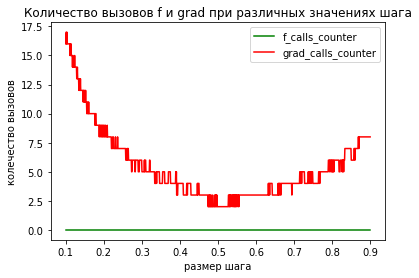

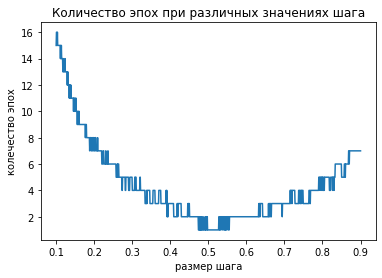

In [27]:
compare_dichotomy_to_constant(f, np.asarray([7.]))

Сходимость для шага, вычисленного дихотомией: 57
Количество вызовов функции f: 2086
Количество вызовов функции grad: 2144


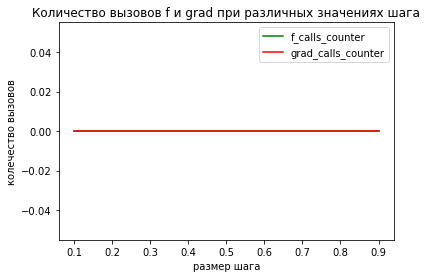

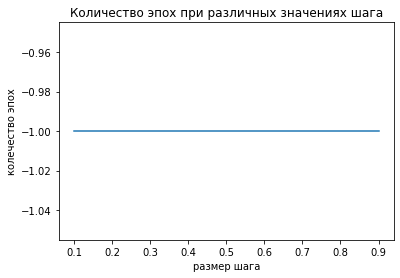

In [28]:
compare_dichotomy_to_constant(function_rosenbrok, np.asarray([0., 0.]))